# Welcome to FI6024 E-tivity 2

The aims of this activity are as follows:

i) To apply time series models (ARMA, ARIMA and EMA) to financial time series data.

ii) To apply portfolio optimization using alpha factors and risk factors derived from principal component analysis (PCA).

#### Your tasks are:

1) Enter your name and UL Student ID in the next section.

2) Run the remainder of the code, taking your time to understand each cell. 

3) Complete Tasks 1-xx where the sections of code are highlighted with #TODO.

#### Student Information:
Your Name: Zheng Hanming

Your Student ID Number: 21225621

### Install Libraries

In [33]:
# pip install -U setuptools 

In [34]:
# pip install SQLAlchemy statsmodels==0.12.2 colour numpy pandas==1.3.5 scipy cvxpy scikit-learn plotly six seaborn 

### Imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import cvxpy as cvx
import plotly as py
import plotly.graph_objs as go
import os
import seaborn as sns
import yfinance as yf
import warnings
warnings.simplefilter(action='ignore')


In [36]:
py.offline.init_notebook_mode(connected=True)
%matplotlib inline
plt.style.use('ggplot')
sns.set()
plt.rcParams['figure.figsize'] = (14, 6)

# Section A: Financial Time Series Analysis

Overview of section A:

### TASK 1

1) Download five years of daily adjusted close prices for ticker XYZ within file pricesTS.csv.

2) Convert the price data to daily log returns.

3) Plot both the price time series and the returns time series.

4) Use autocorrelation to provide insight as to what lag to use for the autoregressive model.

5) Choose a lag value and use the Ljung-Box test to check whether the lag chosen gives autocorrelations that are significantly different from zero.

6) Fit an ARMA model to the log returns.

7) Fit an ARIMA model to the log returns.

### TASK 2

1) Download five years of daily adjusted close prices for any ticker.

2) Calculate the historical volatility of the log returns using standard deviation

3) Create an exponential moving average model of volatility.



### Section A.1 
#### Import the daily adjusted close prices for ticker XYZ and set the index to be the Date column

In [37]:
price_df = pd.read_csv('pricesTS.csv') 
  
price_df = price_df.set_index('Date')
price_df.head()

XYZ
Date                  
01/07/2013  566.657048
02/07/2013  575.976438
03/07/2013  581.433044
05/07/2013  581.508860
08/07/2013  584.052547

#### Calculate Log Returns using the formula $ ln(\frac{p_{t}}{p_{t-1}}) $. using the [`np.log`](https://numpy.org/doc/stable/reference/generated/numpy.log.html) function. Then, use use [numpy.cov](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) to get the covariance.

In [38]:
def calculate_logreturns(close):
    """
    Compute log returns for each ticker and date in close.
    
    Parameters
    ----------
    close : DataFrame
        Close prices for each ticker and date
    
    log_returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    # remove the first row which is the row of NAs after calculation of log returns
    log_returns = np.log(close / close.shift(1)).iloc[1:]
    
    return log_returns

ret = calculate_logreturns(price_df)

ret.head()

XYZ
Date                
02/07/2013  0.016312
03/07/2013  0.009429
05/07/2013  0.000130
08/07/2013  0.004365
09/07/2013  0.000785

#### Visualize the price and returns time series plots. 

See [this source](https://machinelearningmastery.com/time-series-data-visualization-with-python/) for some inspiration with regard to formatting.

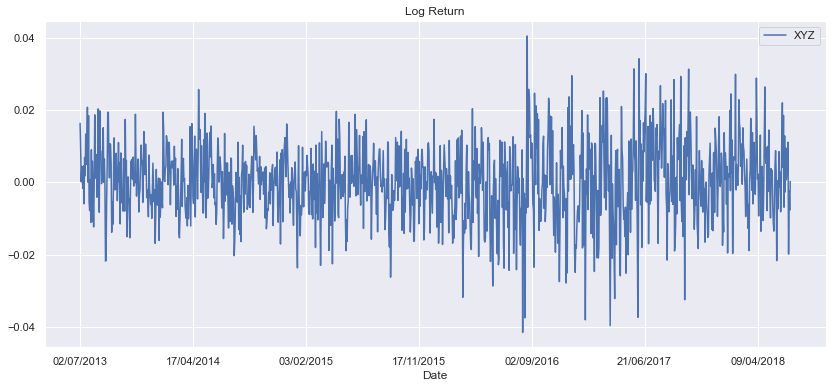

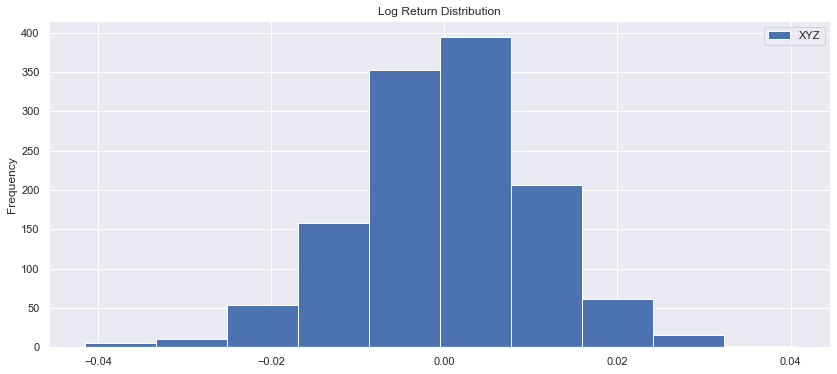

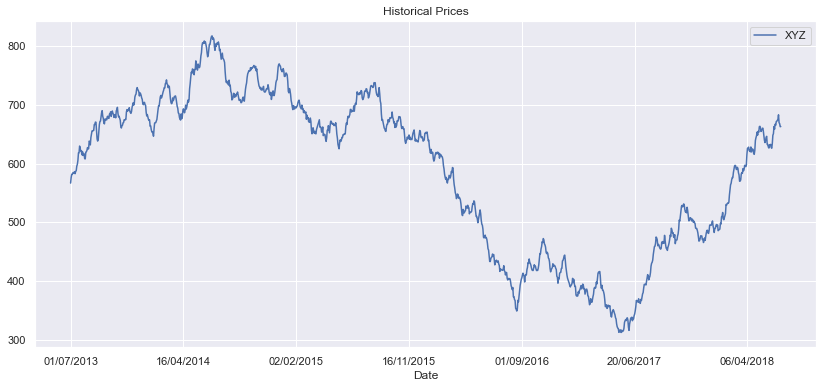

In [39]:
ret.plot(title="Log Return", kind="line")
plt.show()
ret.plot(title="Log Return Distribution", kind="hist")
plt.show()
price_df.plot(title="Historical Prices")
plt.show()

### Testing for stationarity
##### Plot the autocorrelation and partial autocorrelation function of the log returns

A stationary time series is a series in which statistical properties such as mean, variance, and covariance are constant over time. Stationarity is a desired characteristic of time series as it makes modeling and extrapolating (forecasting) into the future more feasible [(Lewinson 2020)](https://www.oreilly.com/library/view/python-for-finance/9781789618518/8182e0f2-3bfc-4821-a939-a428729b52dd.xhtml).

Use the [`plot_acf`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) function from the statsmodels.graphics.tsaplots library to produce this helpful visualisation tool. This plot may help determine what lag `p` to use for an autoregressive time-series model.

[ACF](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8) is a complete autocorrelation function which gives us values of autocorrelation of any series with its lagged values. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’. 

Use the [`plot_pacf`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html) function from the statsmodels.graphics.tsaplots library to produce this helpful visualisation tool. This plot is also helpful in determining what lag `p` to use for an autoregressive time-series model.

[PACF](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8) is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals with the next lag value.

Further information: [here](https://www.ibm.com/docs/en/spss-modeler/SaaS?topic=data-autocorrelation-partial-autocorrelation-functions)

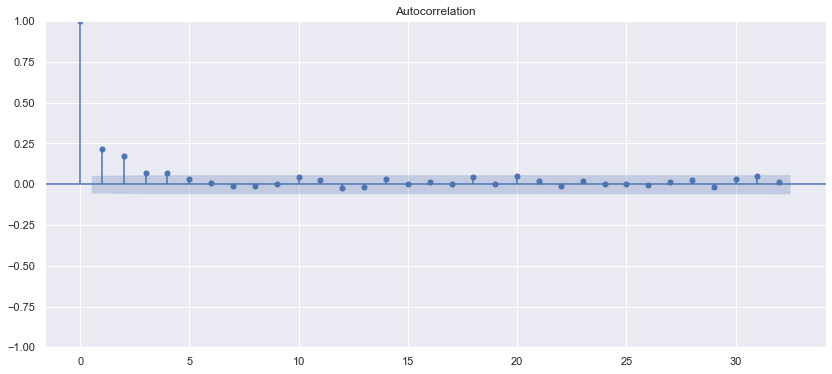

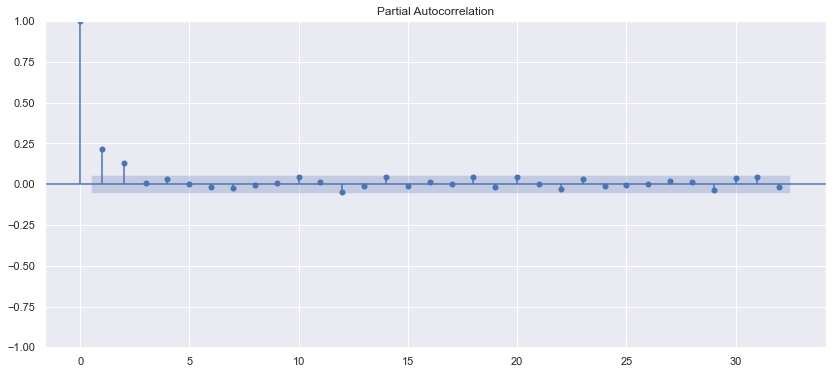

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

acf_ret = plot_acf(ret)
plt.show()
pacf_ret = plot_pacf(ret)
plt.show()

##### Provide a brief interpretation of these plots and how it might be used for an ARMA/ARIMA model.

Autocorrelation(ACF) & Partial Autocollrection(PACF) show the extent which current values are correlated with previous values given a certain amount of lags. They are useful for determining the value of P and Q.

1. ACF Plot can help to determine the value of q. Q value can be determined by observing the lag where the plot first cuts through the upper confidence interval. Q = 4
2. PACF Plot can help to determine the value of p. P value can be determined by observing the lag where the plot first cuts through the upper confidence interval. P = 2

https://people.duke.edu/~rnau/411arim2.htm

#### Ljung-Box Test

Use the Ljung-Box test ([acorr_ljungbox](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)) on the log returns to check whether the previous ten lag periods give autocorrelations that are significantly different from zero.  

The null hypothesis is that the previous lags as a whole are not correlated with the current period.  If the p-value is small enough (say 0.05), we can reject the null and assume that the past lags have some correlation with the current period.

```
returns:
lbvalue (float or array) – test statistic
pvalue (float or array) – p-value based on chi-square distribution
```

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(ret, lags=10)
result.lb_pvalue

1     2.016407e-14
2     1.241233e-21
3     5.105014e-22
4     1.864462e-22
5     6.136882e-22
6     2.968113e-21
7     1.183924e-20
8     4.642323e-20
9     1.789354e-19
10    2.367707e-19
Name: lb_pvalue, dtype: float64

##### Provide a brief interpretation of this test and how it might be used for an ARMA/ARIMA model.

H<sub>0</sub>: is that the previous lags as a whole are not correlated with the current period\
All the p-values are < 0.05, we can reject the H<sub>0</sub> and assume that the past lags have some correlations with the current period.

This is a confirmation of previous PAF and PACF plots which means that the previously selected P & Q values(< 10) are inline with the Ljung-Box test.


#### Fit an ARMA model to the log returns data

Based on previous analysis, choose values for the autoregression lag (p) and the moving average lag (q) to find a model that best fits the data. 

Check out the [statsmodel arma](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html) documentation for further information.

In [42]:
from statsmodels.tsa.arima.model import ARIMA

def fit_arma(lret):
    """
    Fit an ARMA model to log returns dataframe.
    
    Parameters
    ----------
    lret : DataFrame
        Log returns dataframe
    
    Returns
    -------
    fittedvalues : 1 dimensional Ndarray
        The predicted values of the model.
    
    arparams : 1 dimensional Ndarray
        The parameters associated with the AR coefficients in the model.
        
    maparams : 1 dimensional Ndarray
        The value of the moving average coefficients.
        
    """        
    # autoregression lag 
    AR_lag_p = 2
    
    # moving average lag 
    MA_lag_q = 4
    
    # ARMA model >> d = 0
    d = 0

    # Create a tuple of p,d,q
    order = (AR_lag_p, d, MA_lag_q)
    
    # create an ARMA model object, passing in the values of the ret pandas series,
    # and the tuple containing the (p,d,q) order arguments
    arma_model = ARIMA(lret, order=order)
    
    arma_result = arma_model.fit()
    
    # From the result of calling ARMA.fit(),
    # save and return the fitted values, autoregression parameters, and moving average parameters
    fittedvalues = arma_result.fittedvalues
    arparams = arma_result.arparams
    maparams = arma_result.maparams
    
    return fittedvalues,arparams,maparams,arma_result.summary()

fitted AR parameter 0.80, MA parameter -0.62
                               SARIMAX Results                                
Dep. Variable:                    XYZ   No. Observations:                 1259
Model:                 ARIMA(2, 0, 4)   Log Likelihood                3974.934
Date:                Fri, 25 Nov 2022   AIC                          -7933.868
Time:                        20:59:06   BIC                          -7892.763
Sample:                             0   HQIC                         -7918.421
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.288      0.773      -0.001       0.001
ar.L1          0.8044      0.479      1.680      0.093      -0.134       1.743
ar.L2  

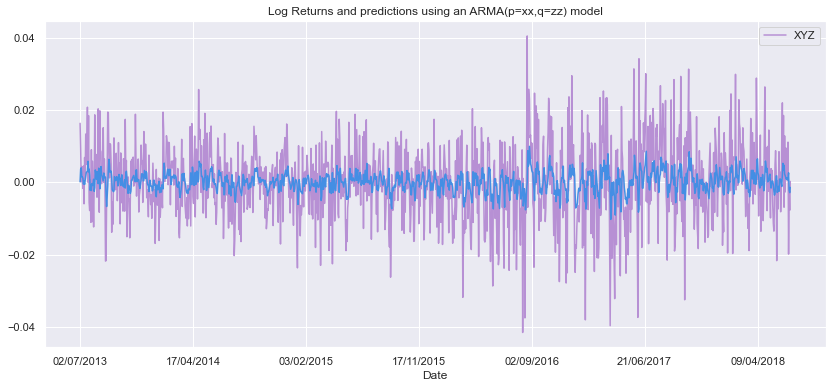

In [43]:
#Test your function:
fittedvalues,arparams,maparams,summary = fit_arma(ret)
arma_pred = pd.Series(fittedvalues)

#Plot your log returns vs your predictions:
ret.plot(color=sns.xkcd_rgb["pale purple"])
arma_pred.plot(color=sns.xkcd_rgb["dark sky blue"])
plt.title('Log Returns and predictions using an ARMA(p=xx,q=zz) model')
print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")
print(summary)


#### Fit an ARIMA model to the log returns data

Informed by your previous analysis, choose values for the autoregression lag (p), moving average lag (q) and order of integration (d) to find a model that best fits the data.

Check out the [statsmodels arima](http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARMAResults.html) documentation for further information.

In [44]:
from statsmodels.tsa.arima.model import ARIMA

def fit_arima(lret):
    """
    Fit an ARIMA model to log returns dataframe.
    
    Parameters
    ----------
    lret : DataFrame
        Log returns dataframe
    
    Returns
    -------
    fittedvalues : 1 dimensional Ndarray
        The predicted values of the model.
    
    arparams : 1 dimensional Ndarray
        The parameters associated with the AR coefficients in the model.
        
    maparams : 1 dimensional Ndarray
        The value of the moving average coefficients.
        
    """    
    # autoregression lag 
    AR_lag_p = 2
    
    # moving average lag 
    MA_lag_q = 4
     
    # order of integration 
    order_of_integration_d = 1
    
    # Create a tuple of p,d,q
    order = (AR_lag_p, order_of_integration_d, MA_lag_q,)
    
    # create an ARIMA model object, passing in the values of the ret pandas series,
    # and the tuple containing the (p,d,q) order arguments
    arima_model = ARIMA(lret,order=order)
    
    arima_result = arima_model.fit()
    
    # From the result of calling ARIMA.fit(),
    # save and return the fitted values, autoregression parameters, and moving average parameters
    fittedvalues = arima_result.fittedvalues
    arparams = arima_result.arparams
    maparams = arima_result.maparams
   
    return fittedvalues,arparams,maparams,arima_result.summary()

fitted AR parameter -0.94, MA parameter 0.13
                               SARIMAX Results                                
Dep. Variable:                    XYZ   No. Observations:                 1259
Model:                 ARIMA(2, 1, 4)   Log Likelihood                3963.502
Date:                Fri, 25 Nov 2022   AIC                          -7913.005
Time:                        20:59:09   BIC                          -7877.044
Sample:                             0   HQIC                         -7899.490
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9379      0.666     -1.409      0.159      -2.243       0.367
ar.L2         -0.2095      0.178     -1.176      0.240      -0.559       0.140
ma.L1  

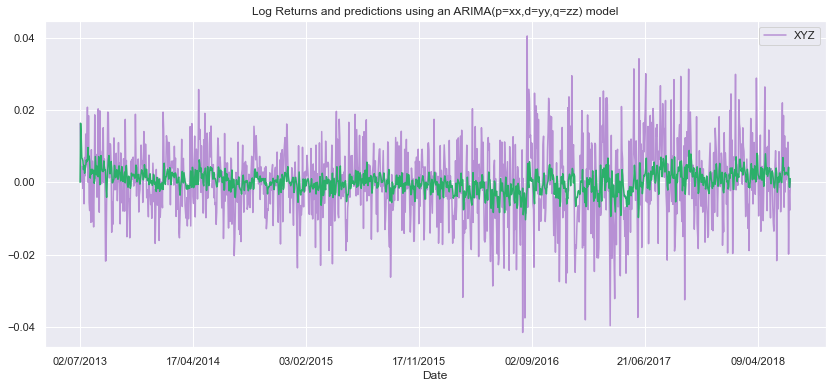

In [45]:
#Test your function:
fittedvalues,arparams,maparams,summary = fit_arima(ret)
arima_pred = pd.Series(fittedvalues)

#Plot your log returns vs your predictions:
ret.plot(color=sns.xkcd_rgb["pale purple"])
arima_pred.plot(color=sns.xkcd_rgb["jade green"])
plt.title('Log Returns and predictions using an ARIMA(p=xx,d=yy,q=zz) model');
print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")
print(summary)


##### Provide a brief interpretation of the fitted ARMA and ARIMA models and their ability to predict log returns of XYZ.

Looking at the two plots. Neither ARMA and ARIMA seems to be a good fit for predicting log returns of XYZ. The predictions have pretty huge differences.

For the P values(in SARIMAX Results) in both models, we see that none of them are below 0.05 except sigma2. From this we can conclude that neither model is accurately predicting the log returns of XYZ.

### Section A.2

#### Download five years of daily adjusted close prices for any ticker

Use [yfinance](https://pypi.org/project/yfinance/) or otherwise to download five years of daily adjusted close prices for any ticker of your choosing between Jul 01, 2013 and Jun 29, 2018.

In [46]:
price_df = yf.download(['AAPL'], start='2013-07-01', end='2018-06-29', progress=False)
price_df = price_df['Adj Close']
price_df.head()

Date
2013-07-01    12.725652
2013-07-02    13.013923
2013-07-03    13.085758
2013-07-05    12.980650
2013-07-08    12.906948
Name: Adj Close, dtype: float64

#### Calculate the historical volatility of the log returns using standard deviation

Hint: Use [np.std()](https://numpy.org/doc/stable/reference/generated/numpy.std.html) to calculate the historical volatility of the log returns.

In [47]:
# Use calculate_logreturns() or otherwise to calculate log returns. Remove the first row of NaNs.
ret_Ticker = calculate_logreturns(price_df)

# Calculate the historical volatility of ret_Ticker
std_Ticker = np.std(ret_Ticker)
print("Most recent historical volatility estimate: {:.6f}".format(std_Ticker))

Most recent historical volatility estimate: 0.014397


#### Create an exponential moving average model of volatility. 

Use the formula: 

$ \sigma_{n}^2 = \frac{r_{n}^2 + \lambda^1r_{n-1}^2 + \lambda^2r_{n-2}^2+ ...+ \lambda^nr_{0}^2}{1+ \lambda^1 + \lambda^2 + ... +\lambda^n} $

where $r_{n}$ is the nth daily return, and $\sigma_n$ is the nth estimate of the volatility. 

$\lambda$ is a constant between 0 and 1 that defines how quickly weights on older data should decrease. A high value of $\lambda$ (close to 1) will cause older data to matter relatively more in the calculation of $\sigma_n$. A very low value of $\lambda$ will mean that recent data matter more — in this case, the successive daily estimates of $\sigma_n$ themselves will be volatile.

Pandas provides built-in exponentially weighted moving window functions with the [`.ewm`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html?highlight=ewm#pandas.DataFrame.ewm) method. Consider using ``.ewm().mean(),`` and be sure to properly specify the alpha parameter (hint: it is related to, but not equal to $\lambda$).

In [48]:
def estimate_volatility(lret, l):
    """Create an exponential moving average model of the volatility of a stock
    price, and return the most recent (last) volatility estimate.
    
    Parameters
    ----------
    lret : DataFrame
        Log returns dataframe
        
    l : float
        The 'lambda' parameter of the exponential moving average model. Making
        this value smaller will cause the model to weight older terms less 
        relative to more recent terms.
        
    Returns
    -------
    last_vol : float
        The last element of your exponential moving averge volatility model series.
    
    """
    
    return np.sqrt((lret**2).ewm(alpha=1-l).mean()).iloc[-1]

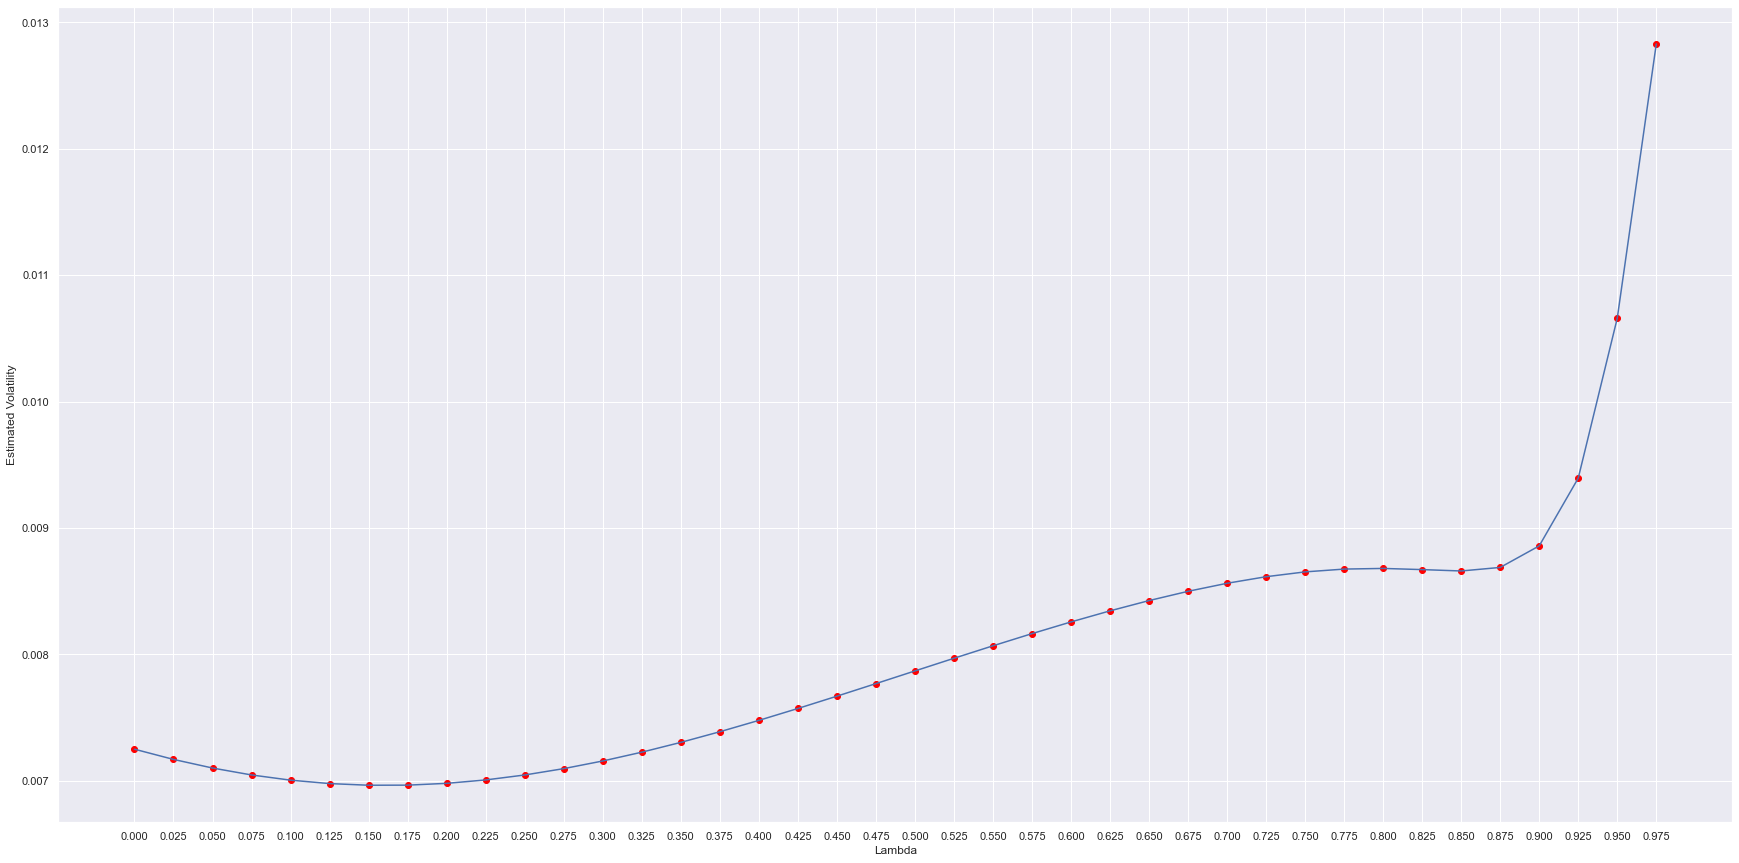

Most recent EWMA volatility estimate(lambda: 0.9): 0.008858


In [49]:
# Implement your function using the log returns and an intuitive value for lambda.
lambdas = np.arange(0, 1, 0.025)
volatilities = [estimate_volatility(ret_Ticker, l) for l in lambdas]

plt.figure(figsize=(30, 15))
plt.plot(lambdas, volatilities)
plt.scatter(lambdas, volatilities, color='red')
plt.xticks(lambdas)
plt.xlabel('Lambda')
plt.ylabel('Estimated Volatility')
plt.show()

print(f"Most recent EWMA volatility estimate(lambda: 0.9): {estimate_volatility(ret_Ticker, 0.9):.6f}") # TODO 

##### Provide a brief comment on the volatility estimates, providing an explanation for your chosen $\lambda$

The $\lambda$ chosen will be based on the estimated volatility. With high $\lambda$, the older data matters more in the calculation of volatility. The $\lambda$ I chose is 0.9, at this level, the volatility of the return is still within an acceptable range based the graph. After 0.9, the volatility spikes up significantly.

## Reflection Markdown Section

This etivity is very difficult for me as the learning curve is very steep. It is hard to understand and do the etivity within this short period of time. However, it gets better with the discussion in the forum. I learnt a lot from the forum and below are some examples:
1. The estimation of volatility is the calculation of standard deviation and not variance. Therefore, we have to square root the variance.
2. We have to upgrade the statsmodels and change some code as the library was outdated.
3. ARIMA model can produce a summary to provide more information.

# Section B: Portfolio optimization with an alpha and risk factors

1)	Create a 1-year-momentum-based alpha vector from stock price data.

2)	Construct the optimization problem using the alpha vector and apply a set of standard constraints.

3)	Solve the optimization problem.

4)	Create a risk factor model using PCA.

#### Import the daily adjusted close prices for 3 stocks, Stock A, Stock B and Stock C between 2013 to 2017.

<AxesSubplot:title={'center':'Price series'}, xlabel='Date'>

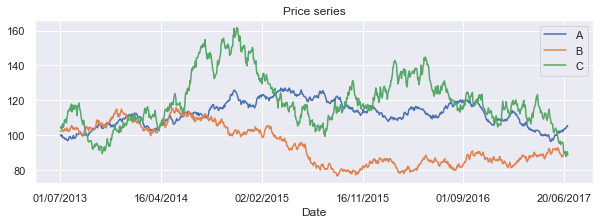

In [50]:
prices = pd.read_csv('pricesPO.csv')
prices = prices.set_index('Date')

prices.plot(figsize=(10,3), title="Price series")

#### Get the log returns for the 3 stocks, Stock A, Stock B and Stock C 

In [51]:
# Use calculate_logreturns() or otherwise to calculate log returns. Remove the first row of NaNs.
ret = calculate_logreturns(prices)
ret.head()

A         B         C
Date                                    
02/07/2013 -0.001279  0.002923  0.007866
03/07/2013 -0.007661  0.004242 -0.005405
05/07/2013  0.008653  0.001396 -0.006014
08/07/2013 -0.011116 -0.003002  0.026135
09/07/2013 -0.005702  0.001512 -0.019277

#### Create an alpha vector based on 1-year momentum

The rolling function from pandas is used to obtain the 1-year (252 trading days) rolling window.  The rolling function helps to provide rolling windows that can be customized through different parameters.  

You can learn more about [rolling function here](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.rolling.html) and also in Lewinson (2020) chapter 3.

In [52]:
from scipy.stats import zscore

def log_returns(series):
    return np.log(series[-1])-np.log(series[0])

# 1-yr momentum alpha
alpha = prices.rolling(window=252).apply(log_returns).rank(axis='columns').apply(zscore, axis='columns')

# Take the most recent set of alpha values on 29/06/2017
alpha_vector = alpha.iloc[-1].to_numpy()
print(alpha_vector)

[ 0.          1.22474487 -1.22474487]


#### Apply Portfolio Optimization with the budget and long-only constraints

Use cvxpy to solve a three-asset portfolio optimization problem. Find the optimal weights on a three-asset portfolio which maximises alpha given the budget and long-only constraints.

$\mathbf{x} = \begin{bmatrix}
x_A & x_B & x_C
\end{bmatrix}
$


Remember that the constraint in this problem are: $x_A + x_B + x_C = 1$,    and   $\mathbf{x} \geq 0$

For this problem, we'll use the optimization objective $-\boldsymbol{\alpha}^T \mathbf{x}$. Remember, we are trying to _minimize_ this function (to maximize alpha). 

First, let's plot $-\boldsymbol{\alpha}^T \mathbf{x}$ as a function of the components of $\mathbf{x}$ so that we can get a better sense of the "shape" of the function.

In [53]:
# Create a plot of possible weights and objective function values

n = 20
x = y = z = np.linspace(-2,2,n)

xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
obj_val = np.full(xv.shape, np.nan)

for i in range(n):
    for j in range(n):
        for k in range(n):
            obj_val[i,j,k] = -alpha_vector[0]*xv[i,j,k]-alpha_vector[1]*yv[i,j,k]-alpha_vector[2]*zv[i,j,k]
            
trace1 = go.Scatter3d(
    x=xv.flatten(),
    y=yv.flatten(),
    z=zv.flatten(),
    mode='markers',
    marker=dict(
        size=4,
        color=obj_val.flatten(),     # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        colorbar=dict(
                title='Objective Function'
            ),
        opacity=0.4,
        showscale=True
    ),
    hoverinfo = 'text'
)

data = [trace1]
fig = go.Figure(data=data)
py.offline.iplot(fig)

In this plot, the value of the objective function is represented by the color at each point in weight space. Notice that the function increases with weight on Stock C (z-axis), decreases with weight on Stock B (y-axis), and doesn't depend on the weight on Stock A (x-axis).

In [54]:
def find_optimal_holdings(alpha_vector):
    """Create a function that takes in the alpha vector for a stock universe and returns 
    the vector of optimal weights which maximises alpha subject to the budget and long only constraints.
    
    Parameters
    ----------
    alpha_vector : 1 dimensional Ndarray        
        The alpha vector for the stock universe.
        
    Returns
    -------
    optimal_weights : DataFrame
        A dataframe containing the weights on each stock in the stock universe,
        that alpha subject to the budget and long only constraints.
    """  
    # Create a vector of x variable using the cvx.Variable(?) function
    x = cvx.Variable(len(alpha_vector))
    
    # Define the optimization objective which maximises alpha. 
    # Hint: use -alpha_vector.flatten() to copy the array into one dimension as required. 
    obj = cvx.Minimize(-alpha_vector.flatten() @ x)

    # Define the optimization constraints
    constraints = [sum(x) == 1, x >= 0]

    # Solve for the values of  𝐱 using the cvxpy constructor Problem(objective, constraints), which returns a Problem object.
    # The Problem object has a function solve(), which returns the minimum of the solution.
    prob = cvx.Problem(objective=obj, constraints=constraints)
    prob.solve(verbose=False)

    optimal_weights = np.asarray(x.value).flatten()

    return pd.DataFrame(data=optimal_weights)

In [55]:
# Test your function
optimal_weights = find_optimal_holdings(alpha_vector)
print("Optimal weights: ", optimal_weights)

Optimal weights:                0
0  2.501292e-09
1  1.000000e+00
2  1.240073e-09


##### Provide a brief comment on the Alpha Factor portfolio optimization result.

Alpha is used to describe an investment's ability to beat the market. In this case, it is comparing to the portfolio return.\
From the calculated alphas, only stock B is having a positive alpha. And the result of the optimized holding is 100% stock B because the optimization simply focuses on maximizing alpha.

#### Create a PCA-based Risk Factor Model for our 3 stocks

we will use PCA for **Dimensionality Reduction** of our log returns from three dimensions (i.e. full stock universe) to two factors (principal components). These principal components (PCs) will explain a high percentage of the total variance of the log returns.

Dimensionality reduction is the process of reducing the number of variables used to explain your data.

#### PCA With Scikit-Learn

We can perform principal component analysis on our data using Scikit-Learn's [`PCA()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

Scikit-Learn's `PCA()` class uses a technique called **Singular Value Decomposition (SVD)** to compute the eigenvectors and eigenvalues of a given set of data.

In [56]:
from sklearn.decomposition import PCA

def fitPCA(returns, num_factors):
    
    """Create a function that takes in the log returns and number of factors (PCs) chosen 
    and returns the fitted PCA model.
    
    Parameters
    ----------
    returns : DataFrame       
        Returns for each ticker and date
    
    num_factors : float
        Number of components to keep
        
    Returns
    -------
    mod : object
        Fitted PCA model with n_components equal to num_factors
    
    """
    mod = PCA(n_components=num_factors)
    mod.fit(returns)
    return mod       

Before we apply PCA to our log returns, it is important that we mean normalize the data. Mean normalization will evenly distribute our data in some small interval around zero. Consequently, the average of all the data points will be close to zero.

In [57]:
#First, de-mean the log returns
ret = ret - ret.mean()

In [58]:
#Fit the risk model with 2 factors (i.e., we'll keep 2 PCs)
num_factors = 2

mod = fitPCA(ret, num_factors) # fit the model on our log returns data with 2 factors

# Observe the factors (PCs).
factor_betas = pd.DataFrame(data=mod.components_.T, index=ret.columns)
factor_betas

0         1
A -0.015763  0.059512
B -0.055180 -0.996758
C -0.998352  0.054152

In [59]:
PC_scaler = 0.04 # The PC vectors have length 1, but this is larger than the scale of our data, so for visualization purposes, 
#                  let's plot scaled-down versions of the PCs. 

# Trace for PC 0
pc0 = np.vstack((np.full(3, 0), factor_betas[0].values)).T*PC_scaler

trace4 = go.Scatter3d(
    x=pc0[0],
    y=pc0[1],
    z=pc0[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='#45B39D',
        opacity=0.9,
        symbol="diamond"
    ),
    line=dict(
        color='#45B39D',
        width=3
    ),
    name = 'PC 0',
    hoverinfo = 'text'

)

# Trace for PC 1
pc1 = np.vstack((np.full(3, 0), factor_betas[1].values)).T*PC_scaler

trace5 = go.Scatter3d(
    x=pc1[0],
    y=pc1[1],
    z=pc1[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='#FFC300',
        opacity=0.9,
        symbol="diamond"
    ),
    line=dict(
        color='#FFC300',
        width=3
    ),
    name = 'PC 1',
    hoverinfo = 'text'

)

# Trace for data

trace6 = go.Scatter3d(
    x=ret['A'].values,
    y=ret['B'].values,
    z=ret['C'].values,
    mode='markers',
    marker=dict(
        size=4,
        color='#7FB3D5', 
        opacity=0.3,
    ),
    name = 'daily returns',
    hoverinfo = 'text'
)

data = [trace4, trace5, trace6]

fig = go.Figure(data=data)
py.offline.iplot(fig)

##### Provide a brief comment on the principal component directions [Stock A = x-axis, Stock B = y-axis, Stock C = z-axis]

PCA helps to determine the factors that contributes the most to the portfolio return. From the plot above, we see that x axis is having having any effects on the portfolio return. With a factor of 2, we conclude that only stock B and C will be used for the portfolio allocation.

#### Plot variance explained by our PCA factors

Let's look at the fraction of variance explained by the two factors we kept. This should confirm our intuition about the relative scale of variance explained by the first two factors. 

See [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) documentation to see how to do this.

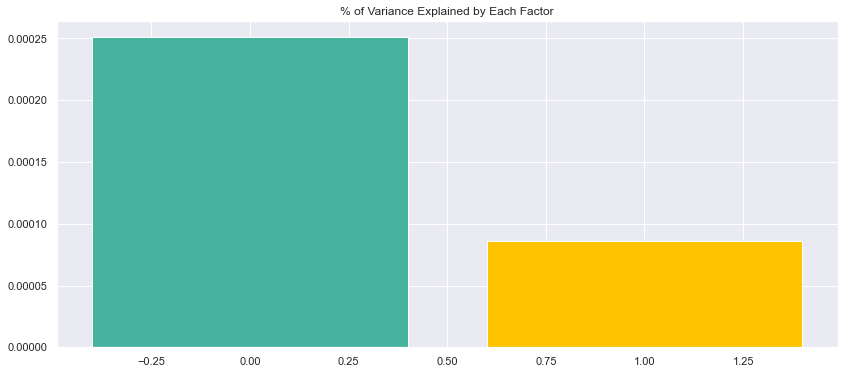

In [60]:
explained_variance_ratio = mod.explained_variance_

plt.bar(np.arange(num_factors), explained_variance_ratio, color=['#45B39D', '#FFC300']);
plt.title('% of Variance Explained by Each Factor');

#### Plot PCA Factor Returns and Log Returns

Now let's look at the factor returns. We'll convert them to "price series" and visualize the evolution of these over time. Recall that these are the data expressed in the "factor" (PC) basis––the projections of the data vectors onto the factor dimensions.

<AxesSubplot:xlabel='Date'>

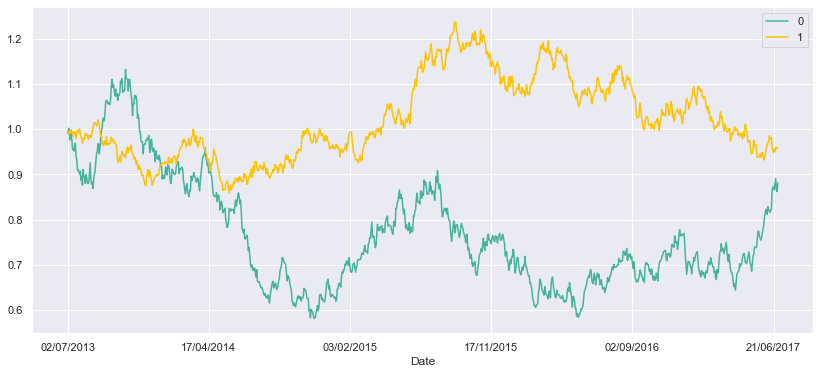

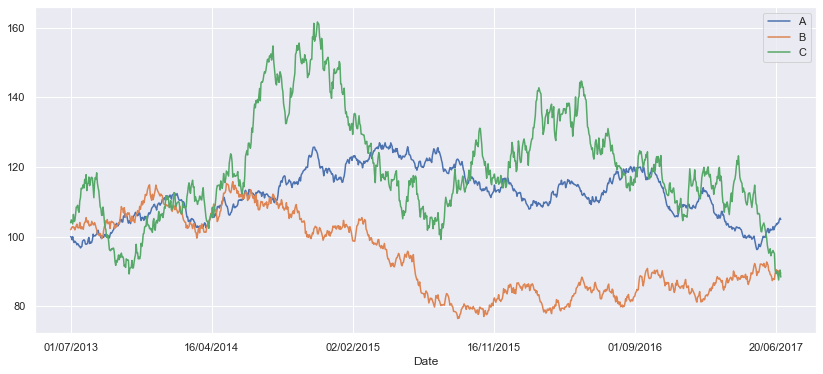

In [61]:
factor_returns = pd.DataFrame(data=mod.transform(ret), index=ret.index)

(factor_returns + 1).cumprod().plot(color=['#45B39D', '#FFC300'])
prices.plot()

##### Provide a brief comment on the factor returns for PC1 and PC2 versus the full 3 stock universe.

The Factor plot(top) show normalized data which the data starts from 1. The price plot on the other hand is not normalized. They seem to start from the same price but this is just an co-incidence as the prices from raw data are close to each other(A:100, B:102, C:104).


#### Apply Portfolio Optimization with Alpha and PCA-based Risk Factors

With our PCA-based Risk Factor Model, we can calculate the portfolio risk with:

$\mathbf{x}^T(\mathbf{B}^T\mathbf{F}\mathbf{B} + \mathbf{S})\mathbf{x}$

Be careful to ensure the matrices are all oriented correctly.

In [62]:
# Using our Risk Factor Model, in the following steps we derive our values for B, F and S.

B = factor_betas #factor sensitivities (Betas) calculated using PCA
F = np.diag(factor_returns.var(axis=0, ddof=1))*252 # Factor Covariance Matrix

common_returns = pd.DataFrame(data=np.dot(factor_returns, factor_betas.T), index=ret.index)
common_returns.columns = ret.columns


# Steps to calculate S Matrix:
residuals = (ret - common_returns)
idio_var_matrix = pd.DataFrame(data=np.diag(np.var(residuals))*252, index=ret.columns)       
idio_var_vector = pd.DataFrame(data=np.diag(idio_var_matrix.values), index=ret.columns)       
idio_var_matrix.columns = index=ret.columns

S = np.diag(idio_var_vector.values.flatten()) # Variance of Specific Returns 

Use cvxpy to solve a three-asset portfolio optimization problem. Find the optimal weights on a three-asset portfolio which maximises alpha.

$\mathbf{x} = \begin{bmatrix}
x_A & x_B & x_C
\end{bmatrix}
$

We will now further constrain our optimization problem using following constraints:
* budget constraint: $\sum_{1}^{n}x = 1$
* long-only constraint: $x_i >0 $ for all $i$

* risk, based on our risk model: $\mathbf{x}^T(\mathbf{B}^T\mathbf{F}\mathbf{B} + \mathbf{S})\mathbf{x} \leq risk\_cap$ 
* factor exposure limits: $B^T\mathbf{x}\leq factor\_max$, and $B^T\mathbf{x} \geq factor\_min$
* individual weight limits: $\mathbf{x}\leq x\_max$, and $\mathbf{x} \geq x\_min$

To calculate our portfolio variance, we need to write $\mathbf{x}^T(\mathbf{B}^T\mathbf{F}\mathbf{B} + \mathbf{S})\mathbf{x}$ in the quadratic form. To do this, we can use the cvxpy function `cvx.quad_form(` $B^T\mathbf{x}$,` F) + cvx.quad_form(x, S)`. Can you see why?

In [63]:
def find_optimal_holdings(alpha_vector, B, F, S, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, x_max=0.55, x_min=-0.55):
    """   
    Parameters
    ----------
    alpha_vector : 1 dimensional Ndarray        
        The alpha vector for the stock universe.

    B : DataFrame        
        The factor sensitivities (Betas) calculated using PCA
    
    F : Ndarray      
        The covariance matrix of the factors

    S : Ndarray       
        Diagonal matrix of variance of Specific Returns 
    
    risk_cap, factor_max, factor_min, x_max, x_min : float
        Optimization constraint constants
        
    Returns
    -------
    optimal_weights : DataFrame
        A dataframe containing the weights on each stock in the stock universe,
        that maximizes alpha subject to the listed constraints.
    """ 
    # Create a vector of x variable using the cvx.Variable(?) function
    x = cvx.Variable(len(alpha_vector))
    
    # portfolio variance, in quadratic form
    f = B.values.T @ x
    risk = cvx.quad_form(f, F) + cvx.quad_form(x, S)

    # Define the optimization objective which maximises alpha.
    # Hint: use -alpha_vector.flatten() to copy the array into one dimension as required.
    obj = cvx.Minimize(-alpha_vector.flatten() @ x)

    # Define the optimization constraints
    c1 = sum(x) == 1
    c2 = x >= 0
    c3 = risk <= risk_cap
    c4 = f <= factor_max
    c5 = f >= factor_min
    c6 = x <= x_max
    c7 = x >= x_min
    constraints = [c1, c2, c3, c4, c5, c6, c7]

    # Solve for the values of  𝐱 using the cvxpy constructor Problem(objective, constraints), which returns a Problem object.
    # The Problem object has a function solve(), which returns the minimum of the solution.
    prob = cvx.Problem(objective=obj, constraints=constraints)
    prob.solve(verbose=False, max_iters=500)

    optimal_weights = np.asarray(x.value).flatten()
    optimal_weights = pd.DataFrame(data=optimal_weights, index=ret.columns)

    return optimal_weights

In [64]:
optimal_weights = find_optimal_holdings(alpha_vector, B, F, S)

optimal_weights

0
A  4.500000e-01
B  5.500000e-01
C  1.521967e-11

#### Provide a brief comment comparing the alpha factor model optimal portfolio weightings to the alpha and risk factor optimal portfolio weightings.

Alpha Factor Portfolio\
This portfolio allocates everything to stock B because it is the only stock that offers positive alpha. And this optimization does not have other complex constraints.

Alpha & Risk Factor Portfolio\
This portfolio optimization on the other hand has a few more constraints such as risk, factor limits and allocation size limits.
- Alpha A: 0
- Alpha B: 1.22474487
- Alpha C: -1.22474487

Based on the optimization, it allocates 45% to stock A and 55% to stock B. It makes sense as stock C is not included in the portfolio because it has negative alpha. Stock A is included as well even though it is having an alpha of 0. The reason for that is the risk and variance limit. I believe by including stock A the portfolio will have lower risk and variance comparing to a portfolio with 100% stock B.

